In [2]:
import torch

import matplotlib.pyplot as plt

In [33]:
a = torch.tensor([1, 2], dtype=float)
b = torch.tensor([1, 3], dtype=float)
c = torch.tensor([1, 4], dtype=float)
d = torch.tensor([1.1, 4], dtype=float)
e = torch.tensor([5, -5], dtype=float)
f = torch.tensor([8, -5], dtype=float)
g = torch.tensor([1, 4.1], dtype=float)
h = torch.tensor([2, 4.1], dtype=float)

In [12]:
def krum(num_byz, grads, p='fro'):
    num_near = len(grads) - num_byz - 2
    scores = []
    for grad in grads:
        dist = torch.norm(grads - grad, p, dim=1)
        dist, _ = torch.sort(dist)
        dist = dist[1:]
        scores.append(torch.sum(dist[:num_near]))
    selected_grad = torch.argmin(torch.tensor(scores))
    
    return grads[selected_grad]

In [13]:
def geomed(grads, epochs, p='fro'):
    losses = []
    y = torch.rand(len(grads[0]))
    for i in range(epochs):
#         losses.append(loss(torch.stack(grads), y))
        num = 0
        for j in range(len(grads)):
            num += grads[j] / torch.norm(grads[j] - y)
        denum = 0
        for j in range(len(grads)):
            denum += 1 / torch.norm(grads[j] - y)
        y = num / denum
    return y

In [17]:
def find_closest_grad(grads, grad):
    # returns the index of the closest gradient to grad in grads
    distances = torch.norm(grads - grad, dim=1)
    return torch.argmin(distances)

In [40]:
def bulyan(grads, num_byz, epochs, geomed):
    f = num_byz
    n = len(grads)
    theta = n - 2 * f

    assert n - 4 * f - 3 >= 0

    selection_set = []
    received_set = grads

    # selection phase
    for i in range(theta):
        aggregated_grad = geomed(received_set, epochs)
        closest_idx = find_closest_grad(received_set, aggregated_grad)
        selection_set.append(grads[closest_idx])

        # removing the closest vector
        idxs = torch.arange(len(received_set)) != closest_idx
        received_set = received_set[idxs]

    # aggregation phase
    beta = theta - 2 * f
    selection_set = torch.stack(selection_set)

    # finding beta closest coordinates to the median you can sort the each
    # coordinate and find the beta closest gradients
    dist_median = torch.abs(selection_set -
                            torch.median(selection_set, dim=0)[0])
    idxs = torch.sort(dist_median, dim=0)[1]
    selection_set = torch.gather(selection_set, 0, idxs)
    return torch.mean(selection_set[:beta, :], dim=0)

In [41]:
def plot_vectors(vectors, selected, labels, file_name=None):
    plt.grid()
    origin = [0], [0]
    avg = torch.mean(vectors, dim=0)
    plt.quiver(*origin, vectors[:, 0], vectors[:, 1], scale=21)
    colors = ['green', 'blue', 'purple']
    for select, label, color in zip(selected, labels, colors):
        plt.quiver(*origin, select[0], select[1], scale=21, color=color, label=label)
    plt.quiver(*origin, avg[0], avg[1], scale=21, color='y', label='avg')
    plt.legend()
    if file_name is not None:
        plt.savefig(file_name + '.pdf', dpi=100, bbox_inches='tight')
    plt.show()

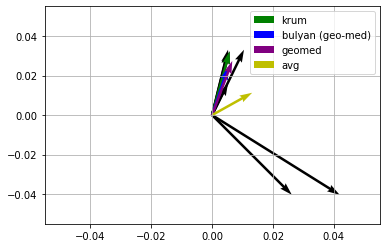

In [43]:
krum_grad = krum(0, torch.stack([a, b, c, d, e, f, g, h]))
bulyan_grad = bulyan(torch.stack([a, b, c, d, e, f, g, h]), 1, 30, geomed)
geomed_grad = geomed(torch.stack([a, b, c, d, e, f, g, h]), 30)
plot_vectors(torch.stack([a, b, c, d, e, f, g, h]), [krum_grad, bulyan_grad, geomed_grad], ['krum', 'bulyan (geo-med)', 'geomed'])